# E - PROJECT SUCESS  - PREDICTOR MODELS - GROUP #41

# Imports

In [0]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

# Basic pandas, numpy and plotting
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import pylab 
import scipy.stats as stats

# Text pipeline and NLP packages
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import tensorflow as tf
import tensorflow_hub as hub
from absl import logging


#Preprocessing and Regression
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

#Bagging
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error

#GAM
!pip install pygam
from pygam import LinearGAM, s, f

#Neural Network imports at the end after checking requirements


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Read the data and Basic overview

In [0]:
# Read csv dataset
path_dataset = 'gdrive/My Drive/CS109BProject/data/Capital_Projects.csv'
df = pd.read_csv(path_dataset)
#df = pd.read_csv('Capital_Projects.csv')
#print(df.shape)
df.replace('', np.nan, inplace=True)
# Drop nan values for the following columns
df = df.dropna(subset=['Budget Forecast', 'Total Budget Changes',
                       'Forecast Completion', 'Total Schedule Changes'], how='all')
# Only take budget forecast for positive values
df = df[df['Budget Forecast'] > 0]
# Reset index to eliminate completely missing rows from the dataframe
df.reset_index(drop=True, inplace=True)
# Keep only last row of each project
df = df.groupby('PID').tail(1)

# Minimize the effect of ZERO schedule change on regression model
new_df = df[df['Total Schedule Changes'] == 0].sample(n=15, random_state=1)
df = df[df['Total Schedule Changes'] != 0]
df = df.append(new_df)

# Minimize the effect of ZERO budget change on regression model
new_df = df[df['Total Budget Changes'] == 0].sample(n=7, random_state=1)
df = df[df['Total Budget Changes'] != 0]
df = df.append(new_df)
df.describe(include='all')

,Date Reported As Of,PID,Project Name,Description,Category,Borough,Managing Agency,Client Agency,Current Phase,Design Start,Budget Forecast,Latest Budget Changes,Total Budget Changes,Forecast Completion,Latest Schedule Changes,Total Schedule Changes
count,301,301.000000,301,298,301,152,301,240,301,294,3.010000e+02,2.480000e+02,2.480000e+02,299,246.000000,246.000000
unique,4,NaN,301,277,21,19,12,29,5,256,NaN,NaN,NaN,252,NaN,NaN
top,09/01/2019 12:00:00 AM,NaN,20th Avenue Storm and Sanitary Sewer Construction,Design and construction of a new school,Streets and Roadways,Brooklyn,DDC,DEP,Construction,05/04/2016,NaN,NaN,NaN,12/31/2019,NaN,NaN
freq,240,NaN,1,16,63,41,152,105,144,7,NaN,NaN,NaN,11,NaN,NaN
mean,NaN,639.368771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.128818e+08,2.684097e+06,2.010676e+07,NaN,66.967480,562.239837
std,NaN,274.070782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.574745e+08,4.023569e+07,8.348361e+07,NaN,216.554972,657.996523
min,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.116642e+06,-2.664272e+08,-2.919002e+08,NaN,-995.000000,-1412.000000
25%,NaN,474.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.595827e+07,0.000000e+00,0.000000e+00,NaN,0.000000,86.500000
50%,NaN,656.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.501760e+07,0.000000e+00,4.953144e+06,NaN,0.000000,450.000000
75%,NaN,868.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.038300e+07,1.000000e+06,2.574161e+07,NaN,91.000000,944.250000


# Data Transformation, Feature Engineering and Plots

In [0]:
#### (1) #### CHANGE object to datetime64[ns] for columns with dates, drop NaNs
df['Forecast Completion'] =pd.to_datetime(df['Forecast Completion'], format='%m/%d/%Y', exact=False)
df['Date Reported As Of'] = pd.to_datetime(df['Date Reported As Of'],format='%m/%d/%Y', exact=False)
df['Design Start'] = pd.to_datetime(df['Design Start'], format='%m/%d/%Y', exact=False)
date_reported_min = min(df['Date Reported As Of'])
date_min = min([min(df['Date Reported As Of']), min(df['Design Start']), min(df['Forecast Completion'])])
print(f'Minimum Date: {date_min}')
print(f'Date Reported Minimum: {date_reported_min}')
df.dtypes

Minimum Date: 1993-08-02 00:00:00
Date Reported Minimum: 2018-08-01 00:00:00


Date Reported As Of        datetime64[ns]
PID                                 int64
Project Name                       object
Description                        object
Category                           object
Borough                            object
Managing Agency                    object
Client Agency                      object
Current Phase                      object
Design Start               datetime64[ns]
Budget Forecast                   float64
Latest Budget Changes             float64
Total Budget Changes              float64
Forecast Completion        datetime64[ns]
Latest Schedule Changes           float64
Total Schedule Changes            float64
dtype: object

In [0]:
### (a) Schedule Change Norm ===>  Change Normalized to Project Duration of each project
df['Project Duration'] = df['Forecast Completion'] - df['Design Start']
df['Schedule Change Norm'] = df['Total Schedule Changes']/(df['Project Duration']/pd.Timedelta(days=1))

### (b) Project Duration Norm ===> Normalized over all projects (to normalize across big and small projects)
max_project_duration = max(df['Project Duration'])
min_project_duration = min(df['Project Duration'])
#df['Project Duration Norm'] = (df['Project Duration'] - min_project_duration) / (max_project_duration - min_project_duration)
df['Project Duration'] = df['Project Duration']/pd.Timedelta(days=1)
print(f'Max Project Duration: {max_project_duration} \nMin Project Duration: {min_project_duration} ')
df.describe()

Max Project Duration: 9736 days 00:00:00 
Min Project Duration: 656 days 00:00:00 


,PID,Budget Forecast,Latest Budget Changes,Total Budget Changes,Latest Schedule Changes,Total Schedule Changes,Project Duration,Schedule Change Norm
count,301.000000,3.010000e+02,2.480000e+02,2.480000e+02,246.000000,246.000000,293.000000,241.000000
mean,639.368771,1.128818e+08,2.684097e+06,2.010676e+07,66.967480,562.239837,2773.535836,0.180054
std,274.070782,2.574745e+08,4.023569e+07,8.348361e+07,216.554972,657.996523,1418.030371,0.218157
min,3.000000,2.116642e+06,-2.664272e+08,-2.919002e+08,-995.000000,-1412.000000,656.000000,-0.722620
25%,474.000000,3.595827e+07,0.000000e+00,0.000000e+00,0.000000,86.500000,1879.000000,0.037037
50%,656.000000,5.501760e+07,0.000000e+00,4.953144e+06,0.000000,450.000000,2429.000000,0.167430
75%,868.000000,9.038300e+07,1.000000e+06,2.574161e+07,91.000000,944.250000,3171.000000,0.310505
max,1014.000000,2.449622e+09,5.322707e+08,8.078026e+08,1413.000000,3253.000000,9736.000000,1.023743


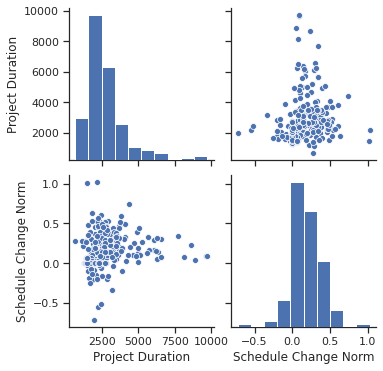

In [0]:
sns.set(style="ticks")
sns.pairplot(df[['Project Duration', 'Schedule Change Norm']])

In [0]:
### (a) Budget Change Norm ===>  Budget Change Normalized to Final Budget of each project
df['Budget Change Norm'] = df['Total Budget Changes']/df['Budget Forecast']

### (b) Total Budget Norm ===> Budget Forecast Normalized through all projects
max_budget_final = max(df['Budget Forecast'])
min_budget_final = min(df['Budget Forecast'])
df['Total Budget Norm'] = (0.9 - 0.1)*(df['Budget Forecast'] - min_budget_final)/(max_budget_final - min_budget_final) + 0.1
print(f'Max Budget: {max_budget_final} \n Min Budget: {min_budget_final}')


Max Budget: 2449621616.0 
 Min Budget: 2116642.0


## Remove Outliers

In [0]:
# Remove outliers
df = df[df['Budget Change Norm'] > -2]
df = df[df['Total Budget Norm'] < 0.3]
min_budget_norm = min(df['Budget Change Norm'])
print(f'Minimum Budget Change Norm: {min_budget_norm}')
df.describe()

Minimum Budget Change Norm: -1.9474624118003965


,PID,Budget Forecast,Latest Budget Changes,Total Budget Changes,Latest Schedule Changes,Total Schedule Changes,Project Duration,Schedule Change Norm,Budget Change Norm,Total Budget Norm
count,235.000000,2.350000e+02,2.350000e+02,2.350000e+02,233.000000,233.000000,230.000000,230.000000,235.000000,235.000000
mean,564.587234,8.243385e+07,1.707614e+06,1.511469e+07,65.296137,548.008584,2872.856522,0.177726,0.137055,0.126253
std,247.255975,7.753500e+07,1.141958e+07,3.633377e+07,201.971731,652.755023,1440.048335,0.218598,0.365015,0.025343
min,3.000000,1.008834e+07,-6.467696e+07,-1.743460e+08,-995.000000,-1412.000000,656.000000,-0.722620,-1.947462,0.102606
25%,431.500000,3.933650e+07,0.000000e+00,0.000000e+00,0.000000,77.000000,1981.250000,0.033659,0.000000,0.112166
50%,588.000000,5.943100e+07,0.000000e+00,4.615000e+06,0.000000,436.000000,2486.000000,0.164496,0.089425,0.118734
75%,761.500000,9.693639e+07,9.704995e+05,2.537455e+07,91.000000,939.000000,3321.250000,0.307498,0.326867,0.130993
max,960.000000,6.137973e+08,7.255500e+07,1.709440e+08,1413.000000,3253.000000,9736.000000,1.023743,1.000000,0.299936


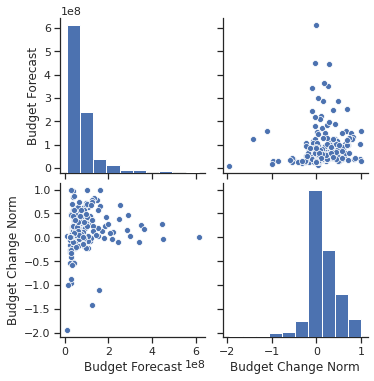

In [0]:
sns.set(style="ticks")
sns.pairplot(df[['Budget Forecast', 'Budget Change Norm']])

## NLP Embedding Preparation

Here is the pipe line for initial data transformation

1. Get the stopwords
2. Change the text to lower case
3. Split the sentences
4. Used PorterStemmer to stem

In [0]:
# Define list of stop words and a function to normalize text
nltk.download('stopwords')
stops = set(stopwords.words("english"))
stops = stops.union(['i','say','like','year','one','also','said','use'])

# Define tokenizer to split sentence into tokens
tokenizer = RegexpTokenizer(r'[a-z]+')

def textNormalize(text):
    textLower = text.lower()
    textList = tokenizer.tokenize(textLower)
    stopped_doc_tokens = [word for word in textList if not word in stops]
    stopstem_doc_tokens0 = [PorterStemmer().stem(word) for word in stopped_doc_tokens]
    stopstem_doc_tokens = [word for word in stopstem_doc_tokens0 if len(word)>1]
    return stopstem_doc_tokens

#example to check how it works
textNormalize(".. 120 I'm in Delhi India,,, today is 2019. went flying")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['delhi', 'india', 'today', 'went', 'fli']

In [0]:
df['Description'] = df['Description'].astype(str)
df['Normalized Description'] = df['Description'].apply(textNormalize)
df['normal_joined'] = df['Normalized Description'].apply(', '.join)
df['normal_joined'] = df['normal_joined'].apply(lambda x: x.replace(', ', ' '))
df.head(n=3)

,Date Reported As Of,PID,Project Name,Description,Category,Borough,Managing Agency,Client Agency,Current Phase,Design Start,Budget Forecast,Latest Budget Changes,Total Budget Changes,Forecast Completion,Latest Schedule Changes,Total Schedule Changes,Project Duration,Schedule Change Norm,Budget Change Norm,Total Budget Norm,Normalized Description,normal_joined
12,2019-09-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Construction,2013-09-23,1.805777e+08,-4664980.0,-4318643.37,2020-10-09,0.0,270.0,2573.0,0.104936,-0.023916,0.158332,"[th, ward, wwtp, mandat, upgrad, preliminari, ...",th ward wwtp mandat upgrad preliminari treatme...
27,2019-09-01,7,Bowery Bay Waste Water Treatment Plant Main Se...,The existing Main Sewage Pumps have deteriorat...,Wastewater Treatment,Queens,DEP,DEP,Construction,2013-05-01,6.879846e+07,1065884.0,15305457.00,2020-02-14,88.0,685.0,2480.0,0.276210,0.222468,0.121796,"[exist, main, sewag, pump, deterior, pump, sys...",exist main sewag pump deterior pump system inc...
42,2019-09-01,18,Croton Falls Pumping Station Construction,This project will construct a new pumping stat...,Water Supply,Carmel,DEP,DEP,Construction,2003-08-22,6.787161e+07,-1399611.0,1255175.02,2020-03-10,91.0,1014.0,6045.0,0.167742,0.018493,0.121493,"[project, construct, new, pump, station, repla...",project construct new pump station replac hydr...


We used Google's Universal Sentence Encoder to create embedding of the normalized sentences.

In [0]:
# Universal sentence encoder 
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


## Adding NLP embedded columns and running PCA to limit # of columns

In [0]:
# The embedding of the description is ready for use in Regression later
embedding = embed(df.normal_joined).numpy()
df_embed = pd.DataFrame(embedding)

pca = PCA(n_components=24)
pc = pca.fit_transform(df_embed)
print(np.sum(pca.explained_variance_ratio_))#percent of variance explained by the the # pc axes chosen
df_pc = pd.DataFrame(pc)
# concatenate the columns related to embedding of project description (512 columns)
df = df.reset_index(drop=True).merge(df_pc.reset_index(drop=True), left_index=True, right_index=True)

0.6096717


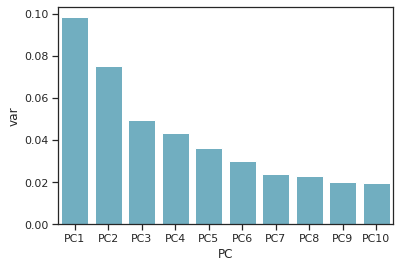

In [0]:
display_df = pd.DataFrame({'var':pca.explained_variance_ratio_[0:10], 'PC':['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8', 'PC9','PC10']})
sns.barplot(x='PC', y='var',data=display_df, color='c')

## Adding Dummy variables and dropping categorical columns

In [0]:
####  (4)  #### Handle Categorical Columns using dummy variables
categorical_columns = ['Category', 'Borough'] # not including Agencies nor Decription
nyc_df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

#### (5) #### Drop redundant or useless columns, and drop NaNs
drop_columns = ['Date Reported As Of', 'PID', 'Project Name', 'Description','Managing Agency', 
                'Client Agency', 'Design Start', 'Total Budget Norm', 'Latest Budget Changes', 
                'Latest Schedule Changes', 'Total Schedule Changes', 'Total Budget Changes', 
                'Forecast Completion', 'Current Phase']
nyc_df = nyc_df.drop(drop_columns, axis=1, errors='ignore')

## Transformation

In [0]:
# TRANSFORMATION
# Log of both Project Duration and Budget Forecast
nyc_df['Budget Forecast'] = np.log(nyc_df['Budget Forecast'])
nyc_df['Project Duration'] = np.log(nyc_df['Project Duration'])
nyc_df.describe()

,Budget Forecast,Project Duration,Schedule Change Norm,Budget Change Norm,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,Category_Bridges,"Category_Bridges, Streets and Roadways",Category_Ferries,Category_Health and Hospitals,"Category_Health and Hospitals, IT",Category_IT,Category_Industrial Development,"Category_Industrial Development, Streets and Roadways",Category_Libraries,Category_Other Government Facilities,Category_Parks,Category_Public Safety and Criminal Justice,Category_Sanitation,Category_Schools,Category_Sewers,Category_Streets and Roadways,Category_Wastewater Treatment,Category_Water Supply,"Borough_Bronx, Manhattan",Borough_Brooklyn,"Borough_Brooklyn, Queens",Borough_Carmel,Borough_Citywide,Borough_Manhattan,"Borough_Manhattan, Bronx","Borough_Manhattan, Staten Island","Borough_Manhattan, Staten Island, Bronx",Borough_Manhatten,Borough_New York,Borough_Olive,Borough_Port Jervis,Borough_Queens,Borough_Staten Island,Borough_Upstate,Borough_Valhalla
count,235.000000,230.000000,230.000000,235.000000,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000
mean,17.963800,7.867122,0.177726,0.137055,-2.155913e-09,9.384561e-09,1.530539e-08,8.211491e-09,-5.960465e-09,-3.328983e-09,-7.735922e-09,-3.170460e-11,-4.280121e-09,1.410855e-09,7.831035e-09,-8.100525e-09,1.141366e-09,5.706828e-09,8.068820e-09,9.828425e-09,-1.918128e-09,5.611714e-09,-2.092504e-09,3.899665e-09,1.945870e-09,7.799331e-09,7.942002e-09,4.260305e-09,0.080851,0.059574,0.017021,0.017021,0.004255,0.008511,0.114894,0.004255,0.008511,0.042553,0.012766,0.046809,0.017021,0.051064,0.127660,0.187234,0.093617,0.093617,0.004255,0.165957,0.004255,0.004255,0.029787,0.085106,0.008511,0.004255,0.004255,0.004255,0.004255,0.004255,0.004255,0.127660,0.046809,0.008511,0.004255
std,0.679063,0.421443,0.218598,0.365015,2.761015e-01,2.413461e-01,1.961733e-01,1.836040e-01,1.678683e-01,1.520521e-01,1.356440e-01,1.337039e-01,1.249290e-01,1.230308e-01,1.194549e-01,1.142510e-01,1.127235e-01,1.101347e-01,1.061684e-01,1.048169e-01,1.042085e-01,1.001602e-01,9.781866e-02,9.755045e-02,9.425825e-02,9.151791e-02,8.984030e-02,8.773608e-02,0.273188,0.237202,0.129627,0.129627,0.065233,0.092056,0.319574,0.065233,0.092056,0.202278,0.112503,0.211679,0.129627,0.220598,0.334423,0.390932,0.291917,0.291917,0.065233,0.372837,0.065233,0.065233,0.170363,0.279636,0.092056,0.065233,0.065233,0.065233,0.065233,0.065233,0.065233,0.334423,0.211679,0.092056,0.065233
min,16.126891,6.486161,-0.722620,-1.947462,-4.745968e-01,-4.947568e-01,-4.153929e-01,-4.332487e-01,-4.359955e-01,-4.358863e-01,-4.243422e-01,-2.944617e-01,-3.779839e-01,-3.381519e-01,-3.078300e-01,-2.759200e-01,-2.905627e-01,-2.937711e-01,-2.718052e-01,-3.096624e-01,-2.808807e-01,-3.193868e-01,-2.443752e-01,-2.264046e-01,-2.273749e-01,-2.337453e-01,-2.635375e-01,-2.155047e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.487651,7.591483,0.033659,0.000000,-2.072938e-01,-1.915883e-01,-1.366703e-01,-1.264513e-01,-9.026958e-02,-8.615405e-02,-8.990994e-02,-6.978374e-02,-7.101182e-02,-8.271722e-02,-6.817913e-02,-8.144664e-02,-7.039882e-02,

## Test Train Split

In [0]:
nyc_df = nyc_df.dropna()
np.random.seed(49)
nyc_train, nyc_test = train_test_split(nyc_df, test_size=.1, random_state=49)

In [0]:
nyc_train.head()

,Budget Forecast,Project Duration,Schedule Change Norm,Budget Change Norm,Normalized Description,normal_joined,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,Category_Bridges,"Category_Bridges, Streets and Roadways",Category_Ferries,Category_Health and Hospitals,"Category_Health and Hospitals, IT",Category_IT,Category_Industrial Development,"Category_Industrial Development, Streets and Roadways",Category_Libraries,Category_Other Government Facilities,Category_Parks,Category_Public Safety and Criminal Justice,Category_Sanitation,Category_Schools,Category_Sewers,Category_Streets and Roadways,Category_Wastewater Treatment,Category_Water Supply,"Borough_Bronx, Manhattan",Borough_Brooklyn,"Borough_Brooklyn, Queens",Borough_Carmel,Borough_Citywide,Borough_Manhattan,"Borough_Manhattan, Bronx","Borough_Manhattan, Staten Island","Borough_Manhattan, Staten Island, Bronx",Borough_Manhatten,Borough_New York,Borough_Olive,Borough_Port Jervis,Borough_Queens,Borough_Staten Island,Borough_Upstate,Borough_Valhalla
131,18.118656,7.991592,0.294993,0.573541,"[renov, floor, build, creat, new, offic, space...",renov floor build creat new offic space landma...,0.378296,-0.138520,-0.107196,-0.052663,0.212140,-0.029756,0.079618,-0.158910,0.059479,-0.017234,0.115364,0.093085,0.038537,-0.112569,0.105779,0.222975,0.014551,-0.072266,-0.145716,-0.038207,0.058741,-0.118423,0.080090,-0.003207,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
234,17.087662,7.728856,0.007039,0.000000,"[new, utrech, branch, librari, comprehens, int...",new utrech branch librari comprehens interior ...,0.346316,-0.120321,-0.029050,-0.119622,0.172621,-0.045770,0.219152,-0.070200,0.031910,-0.053595,0.103832,-0.037877,-0.187786,0.321802,0.016271,0.097162,-0.049536,-0.060704,-0.174212,-0.059270,-0.015130,-0.233745,0.035537,-0.014803,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67,17.482732,7.991254,0.276142,0.581585,"[distribut, water, main, replac, long, island,...",distribut water main replac long island citi a...,-0.186727,0.108182,0.173693,0.197071,0.190822,0.157678,0.118588,0.026589,-0.178516,-0.070209,-0.059320,-0.009551,0.070407,-0.101742,0.054396,-0.075446,0.141754,0.232974,0.038761,0.133928,0.029936,-0.053989,0.089543,-0.094240,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
96,18.621133,7.784889,0.298253,-0.023311,"[emerg, contract, restor, electr, mechan, syst...",emerg contract restor electr mechan system mov...,0.262255,-0.007899,-0.110794,0.423937,-0.208064,0.047134,-0.058309,0.049046,0.166959,0.137691,-0.203358,-0.063611,0.068899,0.063102,-0.066053,-0.002537,-0.138939,0.149222,0.093904,0.023811,0.022239,-0.053192,0.095802,0.117870,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
156,18.629166,7.820841,0.488764,0.371251,"[design, construct, new, ferri, land, ferri, l...",design construct new ferri land ferri land upg...,0.335517,-0.023815,0.125545,-0.061789,0.368317,0.107447,-0.056860,0.004022,0.017578,-0.048315,0.024662,0.055928,0.201957,-0.041661,0.141830,0.065463,-0.014643,-0.065926,0.070263,0.023379,-0.024728,0.008045,0.079715,-0.001313,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


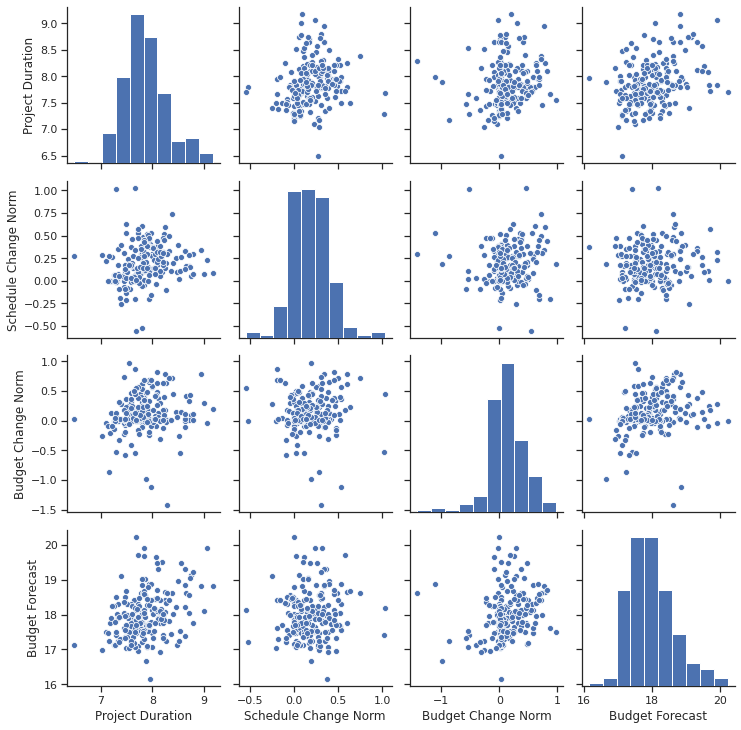

In [0]:
qual_columns = ['Project Duration',	'Schedule Change Norm',
                'Budget Change Norm',	'Budget Forecast']	
#scatter_matrix(nyc_train[qual_columns].sample(frac=0.4, axis=0),alpha=0.5, figsize=(25,20));
plt_df = nyc_train.copy()
sns.set(style="ticks")
sns.pairplot(plt_df[qual_columns])

In [0]:
nyc_train[qual_columns].corr()

,Project Duration,Schedule Change Norm,Budget Change Norm,Budget Forecast
Project Duration,1.000000,0.199344,0.130919,0.359923
Schedule Change Norm,0.199344,1.000000,0.052088,0.088461
Budget Change Norm,0.130919,0.052088,1.000000,0.230264
Budget Forecast,0.359923,0.088461,0.230264,1.000000


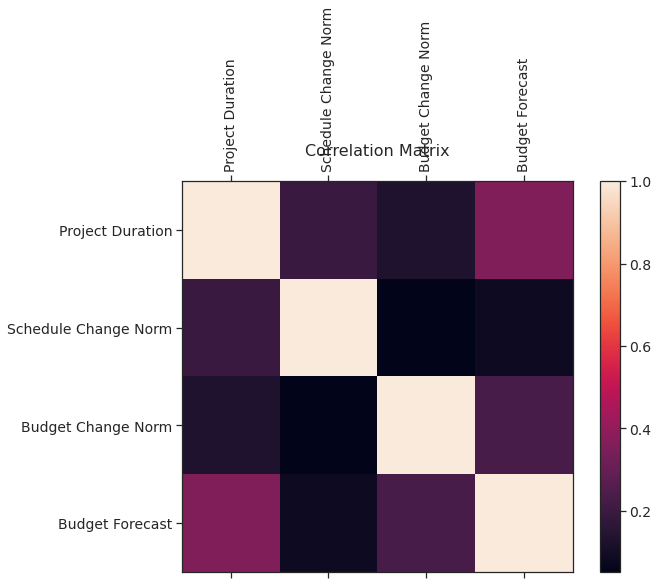

In [0]:
fig = plt.figure(figsize=(10, 7))
plt.matshow(nyc_train[qual_columns].corr(), fignum=fig.number)
plt.xticks(range(len(qual_columns)), qual_columns, fontsize=14, rotation=90)
plt.yticks(range(len(qual_columns)), qual_columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

# Regression - Linear Regression, Lasso, Ridge and Bagging Model

The first set of methods are for Budget Change Model. Then, we have Schedule Change Model.

### Budget Change Model

##### Training and Test Data

In [0]:
# Y = "Budget Change Norm"
# X = "Schedule Change Norm" and "Budget Forecast"
#      Dropped "Project Duration" from X because of its multi-collinearity with 
#      "Budget Forecast" - determined by VIF

nyc_train_trunc = nyc_train.copy()
#nyc_train_trunc = nyc_train_trunc[qual_columns]
y_train = (nyc_train_trunc['Budget Change Norm'])
X_train = nyc_train_trunc.drop(['Budget Change Norm', 'Project Duration'], axis=1)

# Remove redundant columns: found through VIF (multi-collinearity analysis)
drop_mc_columns = ['Category_Health and Hospitals, IT', 'Category_IT', 'Category_Industrial Development, Parks',
                   'Category_Industrial Development, Streets and Roadways', 'Category_Libraries', 
                   'Borough_Brooklyn, Queens','Borough_Manhattan, Staten Island, Bronx', 'Borough_Olive',
                   'Borough_Marlboro', 'Borough_Port Jervis', 'Borough_New York', 
                   'Borough_Carmel','Category_Streets and Roadways', 
                   'Normalized Description', 'normal_joined']
X_train = X_train.drop(drop_mc_columns, axis=1, errors='ignore')

# Test Data
nyc_test_trunc = nyc_test.copy()
#nyc_test_trunc = nyc_test_trunc[qual_columns]
y_test = nyc_test_trunc['Budget Change Norm']
X_test = nyc_test_trunc.drop(['Budget Change Norm', 'Project Duration'], axis=1)
X_test = X_test.drop(drop_mc_columns, axis=1, errors='ignore')

# No need for polynomial interactions - doesn't improve test/training score
# Overfitting - not enough data
#--- poly = PolynomialFeatures(interaction_only=True,include_bias = False)
#--- X_train = poly.fit_transform(X_train)

# No need for increasing polynomial terms - decreases the test scores
# Overfitting - not enough data
#--- X_train['Budget_2T'] = X_train['Budget Forecast'] * X_train['Budget Forecast']
#--- X_train['Budget_3T'] = X_train['Schedule Change Norm'] * X_train['Budget Forecast']
#--- X_train['Project_2T'] = X_train['Project Duration'] * X_train['Project Duration']

#### Linear Regression and RidgeCV

In [0]:
np.random.seed(49)
lr_cost_model = LinearRegression().fit(X_train, y_train)
lr_cost_model.score(X_train, y_train)
alphas = (0.1, 0.5,1,5,10,50,100)
ridge_cost_model = RidgeCV(alphas=alphas, cv=20).fit(X_train, y_train)
lasso_cost_model = LassoCV(alphas=alphas, max_iter=100000).fit(X_train, y_train)

print(f'LinearRegression training score: {lr_cost_model.score(X_train, y_train)}')
print(f'Lasso training score: {lasso_cost_model.score(X_train, y_train)}')
print(f'Ridge training score: {ridge_cost_model.score(X_train, y_train)}')

LinearRegression training score: 0.3508152218976963
Lasso training score: 0.0
Ridge training score: 0.08925568174091969


In [0]:
testr2 = lr_cost_model.score(X_test, y_test)
print(f'LinearRegression test score: {lr_cost_model.score(X_test, y_test)}')
print(f'Lasso test score: {lasso_cost_model.score(X_test, y_test)}')
print(f'Ridge test score: {ridge_cost_model.score(X_test, y_test)}')

LinearRegression test score: 0.1856143789034067
Lasso test score: -0.0028014606265251984
Ridge test score: 0.12581520844023852


In [0]:
print(f'The best test r-squared value so far is {testr2}')

The best test r-squared value so far is 0.1856143789034067


### Bagging Techniques

In [0]:
# BAGGING TECHNIQUES
num_bags = 10
np.random.seed(49)
bagging_train = np.zeros((X_train.shape[0], num_bags))
bagging_test = np.zeros((X_test.shape[0], num_bags))
bagging_models = []
for i in range(num_bags):
  bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
  fitted_model = RidgeCV(alphas=alphas,normalize=True, cv=5).fit(bootstrapped_X, bootstrapped_y)
  bagging_models.append(fitted_model)
  bagging_train[:,i] = fitted_model.predict(X_train)
  bagging_test[:,i] = fitted_model.predict(X_test)

bagging_train_predicts = np.mean(bagging_train[:,:], axis=1)
bagging_test_predicts = np.mean(bagging_test[:,:], axis=1)
print(f'Training score: {mean_squared_error(y_train, bagging_train_predicts)}')
print(f'Test score: {mean_squared_error(y_test, bagging_test_predicts)}')

Training score: 0.0785856500155037
Test score: 0.25858098906775556


In [0]:
X_train_ols = sm.add_constant(X_train)
results = OLS(y_train, X_train_ols).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Budget Change Norm   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     1.686
Date:                Sun, 10 May 2020   Prob (F-statistic):            0.00817
Time:                        00:55:17   Log-Likelihood:                -12.977
No. Observations:                 207   AIC:                             128.0
Df Residuals:                     156   BIC:                             297.9
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -1.3590      0.671     -2.025      0.045      -2.685      -0.033
Budget Forecast                                 0.0865      0.037      2.312      0.022       0.013       0.160
Schedule Change Norm                            0.0430      0.121      0.356      0.722      -0.196       0.282
0                                               0.1865      0.184      1.014      0.312      -0.177       0.550
1                                               0.3096      0.183      1.693      0.093      -0.052       0.671
2                                               0.3048      0.194      1.575      0.117      -0.077       0.687
3                                              -0.4788      0.191     -2.504      0.013      -0.856      -0.101
4                                              -0.3231      0.161     -2.002      0.047      -0.642      -0.004
5                                              -0.1187      0.187     -0.634      0.527      -0.488       0.251
6                                               0.0715      0.188      0.381      0.704      -0.299       0.442
7                                               0.0266      0.188      0.142      0.888      -0.345       0.398
8                                              -0.7037      0.201     -3.507      0.001      -1.100      -0.307
9                                              -0.0780      0.200     -0.390      0.697      -0.473       0.317
10                                             -0.0405      0.207     -0.195      0.846      -0.450       0.369
11                                             -0.4333      0.247     -1.756      0.081      -0.921       0.054
12                                             -0.0702      0.215     -0.327      0.744      -0.494       0.354
13                                             -0.7240      0.243     -2.978      0.003      -1.204      -0.244
14                                              0.1670      0.247      0.676      0.500      -0.321       0.655
15                                             -0.2360      0.226     -1.042      0.299      -0.683       0.211
16                                             -0.0005      0.242     -0.002      0.998      -0.478       0.477
17                                             -0.1727      0.242     -0.713      0.477      -0.651       0.306
18                                             -0.1959      0.222     -0.884      0.378      -0.633       0.242
19                                              0.1456      0.241      0.603      0.547      -0.331       0.622
20                                              0.3312      0.266      1.247      0.214      -0.193       0.856
21                                              0.1233     

In [0]:
# Multi-collinearity
X_train_save = X_train.copy()
pd.Series([variance_inflation_factor(X_train.values, i) 
               for i in range(X_train.shape[1])], 
               index=X_train.columns)

Budget Forecast                                10.514463
Schedule Change Norm                            2.728001
0                                               5.621382
1                                               4.390047
2                                               3.457591
3                                               2.783835
4                                               1.807592
5                                               1.877452
6                                               1.554810
7                                               1.568576
8                                               1.423165
9                                               1.370201
10                                              1.390782
11                                              1.893911
12                                              1.388986
13                                              1.580867
14                                              1.521776
15                             

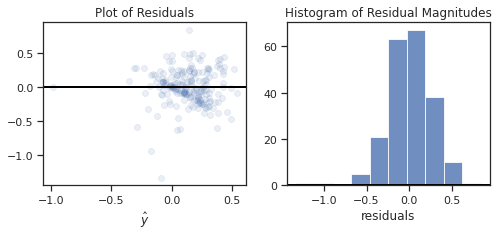

In [0]:
# Residual Plots
y_hat_train = results.predict()
residuals = (y_train - y_hat_train)
fig, axes = plt.subplots(1,2,figsize=(8,3))
axes[0].set_title('Plot of Residuals')
axes[0].scatter((y_hat_train), residuals, alpha=0.1)
axes[0].axhline(0, c='black', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')
axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(residuals, alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
axes[1].set_xlabel(r'residuals')
plt.show()


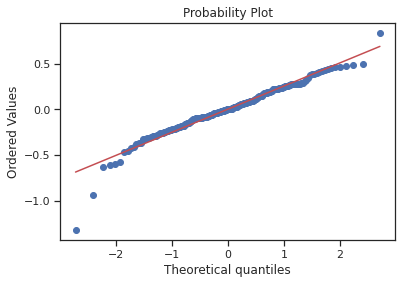

In [0]:
stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()

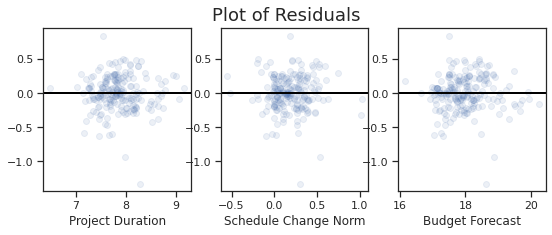

In [0]:
# Residual Plots
X_colms = ['Project Duration','Schedule Change Norm','Budget Forecast']
y_hat_train = results.predict()
residuals = y_train - y_hat_train

fig, axes = plt.subplots(1,3,figsize=(9,3))
fig.suptitle('Plot of Residuals', fontsize=18)
for i in range(3):
  x_val = y_hat_train
  x_lbl = r'$\hat{y}$'
  if i > -1:
    x_val = nyc_train[X_colms[i]].ravel()
    x_lbl = X_colms[i]
  row_idx = np.mod(i,3)
  col_idx = int(i / 3) 
  axes[row_idx].scatter(x_val, residuals, alpha=0.1)
  axes[row_idx].axhline(0, c='black', lw=2)
  axes[row_idx].set_xlabel(x_lbl, fontsize=12)
plt.show()

### Schedule Change Model

##### Training and Test Data

In [0]:
# Schedule change
nyc_train_trunc2 = nyc_train.copy()
#nyc_train_trunc = nyc_train_trunc[qual_columns]
y_train2 = (nyc_train_trunc2['Schedule Change Norm'])
X_train2 = nyc_train_trunc2.drop(['Schedule Change Norm', 'Budget Forecast'], axis=1)
# Remove redundant columns: found through VIF (multi-collinearity analysis in below cell)
X_train2 = X_train2.drop(drop_mc_columns, axis=1, errors='ignore')

nyc_test_trunc2 = nyc_test.copy()
y_test2 = nyc_test_trunc2['Schedule Change Norm']
X_test2 = nyc_test_trunc2.drop(['Schedule Change Norm', 'Budget Forecast'], axis=1)
X_test2 = X_test2.drop(drop_mc_columns, axis=1, errors='ignore')

##### Linear Regression, LassoCV and RidgeCV

In [0]:
np.random.seed(49)
lr_time_model = LinearRegression().fit(X_train2, y_train2)
ridge_time_model = RidgeCV(alphas=alphas, cv=20).fit(X_train2, y_train2)
lasso_time_model = LassoCV(alphas=alphas, max_iter=100000).fit(X_train2, y_train2)

print(f'LinearRegression train score: {lr_time_model.score(X_train2, y_train2)}')
print(f'Lasso train score: {lasso_time_model.score(X_train2, y_train2)}')
print(f'Ridge train score: {ridge_time_model.score(X_train2, y_train2)}')

LinearRegression train score: 0.3555029104818127
Lasso train score: 0.0
Ridge train score: 0.25781406548992947


In [0]:
print(f'LinearRegression test score: {lr_time_model.score(X_test2, y_test2)}')
print(f'Lasso test score: {lasso_time_model.score(X_test2, y_test2)}')
print(f'Ridge test score: {ridge_time_model.score(X_test2, y_test2)}')

LinearRegression test score: 0.1361692309750543
Lasso test score: -0.09056901439333886
Ridge test score: 0.013661220977818411


### Bagging Model

In [0]:
# BAGGING TECHNIQUES
np.random.seed(49)
bagging_train = np.zeros((X_train2.shape[0], num_bags))
bagging_test = np.zeros((X_test2.shape[0], num_bags))
bagging_models = []
for i in range(num_bags):
  bootstrapped_X, bootstrapped_y = resample(X_train2, y_train2)
  fitted_model = RidgeCV(alphas=alphas,normalize=True, cv=5).fit(bootstrapped_X, bootstrapped_y)
  bagging_models.append(fitted_model)
  bagging_train[:,i] = fitted_model.predict(X_train2)
  bagging_test[:,i] = fitted_model.predict(X_test2)

bagging_train_predicts = np.mean(bagging_train[:,:], axis=1)
bagging_test_predicts = np.mean(bagging_test[:,:], axis=1)
print(f'Training score: {mean_squared_error(y_train, bagging_train_predicts)}')
print(f'Test score: {mean_squared_error(y_test, bagging_test_predicts)}')

Training score: 0.10950685021039869
Test score: 0.3347822236409889


In [0]:
# Multi-collinearity
X_train2_save = X_train2.copy()
pd.Series([variance_inflation_factor(X_train2.values, i) 
               for i in range(X_train2.shape[1])], 
               index=X_train2.columns)

Project Duration                               10.208722
Budget Change Norm                              1.747098
0                                               5.711783
1                                               4.472049
2                                               3.485271
3                                               2.939227
4                                               1.848944
5                                               1.887235
6                                               1.546327
7                                               1.565126
8                                               1.523083
9                                               1.352844
10                                              1.386482
11                                              1.928704
12                                              1.382214
13                                              1.687724
14                                              1.508772
15                             

In [0]:
X_train2_ols = sm.add_constant(X_train2)
results = OLS(y_train2, X_train2_ols).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Schedule Change Norm   R-squared:                       0.356
Model:                              OLS   Adj. R-squared:                  0.149
Method:                   Least Squares   F-statistic:                     1.721
Date:                  Sun, 10 May 2020   Prob (F-statistic):            0.00626
Time:                          00:55:21   Log-Likelihood:                 72.294
No. Observations:                   207   AIC:                            -42.59
Df Residuals:                       156   BIC:                             127.4
Df Model:                            50                                         
Covariance Type:              nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                           0.1082      0.376      0.288      0.774      -0.634       0.850
Project Duration                                0.0015      0.047      0.031      0.975      -0.092       0.095
Budget Change Norm                              0.0185      0.052      0.355      0.723      -0.085       0.122
0                                              -0.0902      0.120     -0.750      0.454      -0.328       0.147
1                                              -0.0964      0.122     -0.791      0.430      -0.337       0.144
2                                              -0.1536      0.129     -1.195      0.234      -0.408       0.100
3                                              -0.1158      0.128     -0.906      0.366      -0.368       0.137
4                                               0.0058      0.111      0.052      0.959      -0.214       0.225
5                                               0.0531      0.128      0.414      0.680      -0.200       0.307
6                                               0.1371      0.124      1.108      0.270      -0.107       0.381
7                                               0.0240      0.125      0.193      0.847      -0.222       0.270
8                                               0.1125      0.138      0.814      0.417      -0.160       0.386
9                                               0.1926      0.134      1.435      0.153      -0.073       0.458
10                                             -0.0989      0.137     -0.720      0.473      -0.370       0.173
11                                              0.0820      0.165      0.498      0.619      -0.244       0.408
12                                              0.1359      0.142      0.957      0.340      -0.145       0.416
13                                              0.0046      0.166      0.028      0.978      -0.323       0.332
14                                             -0.2135      0.164     -1.303      0.194      -0.537       0.110
15                                              0.3121      0.152      2.054      0.042       0.012       0.612
16                                              0.0779      0.161      0.485      0.628      -0.239       0.395
17                                             -0.0215      0.160     -0.134      0.894      -0.338       0.295
18                                              0.0285      0.147      0.193      0.847      -0.262       0.319
19                                              0.1408      0.159      0.887      0.377      -0.173       0.454
20                                              0.0218      0.178      0.122      0.903      -0.331       0.374
21                                   

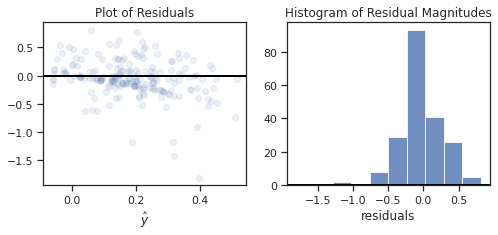

In [0]:
# Residual Plots
y_hat_train = results.predict()
residuals = y_train - y_hat_train
fig, axes = plt.subplots(1,2,figsize=(8,3))
axes[0].set_title('Plot of Residuals')
axes[0].scatter(y_hat_train, residuals, alpha=0.1)
axes[0].axhline(0, c='black', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')
axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(residuals, alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
axes[1].set_xlabel(r'residuals')
plt.show()

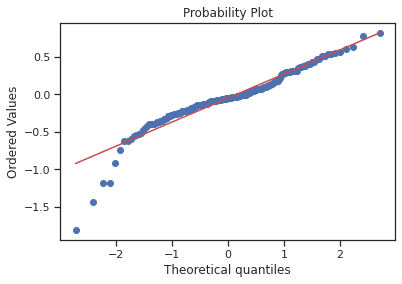

In [0]:
stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()
plt.show()

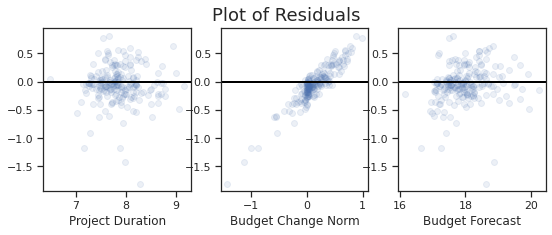

In [0]:
# Residual Plots
X_colms = ['Project Duration','Budget Change Norm','Budget Forecast']
y_hat_train = results.predict()
residuals = y_train - y_hat_train

fig, axes = plt.subplots(1,3,figsize=(9,3))
fig.suptitle('Plot of Residuals', fontsize=18)
for i in range(3):
  x_val = y_hat_train
  x_lbl = r'$\hat{y}$'
  if i > -1:
    x_val = nyc_train[X_colms[i]].ravel()
    x_lbl = X_colms[i]
  row_idx = np.mod(i,3)
  col_idx = int(i / 3) 
  axes[row_idx].scatter(x_val, residuals, alpha=0.1)
  axes[row_idx].axhline(0, c='black', lw=2)
  axes[row_idx].set_xlabel(x_lbl, fontsize=12)
plt.show()

# GAM Models

We will try to apply techniques learned in Generalized Additive Models area in this course 

### Training and Test Data
Using the same training and test data as derived above.

1.   Budget Schedule Change Model: (X_train, Y_train)
2.   Schedule Change Model: (X_train2, Y_train2)

In [0]:
####  (4)  #### Handle Categorical Columns using dummy variables
#categorical_columns = ['Category', 'Borough'] # not including Agencies nor Decription
#nyc_df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
nyc_df_gam = df.copy()

#### (5) #### Drop redundant or useless columns, and drop NaNs
drop_columns = ['Date Reported As Of', 'PID', 'Project Name', 'Description','Managing Agency', 
                'Client Agency', 'Design Start', 'Total Budget Norm', 'Latest Budget Changes', 
                'Latest Schedule Changes', 'Total Schedule Changes', 'Total Budget Changes', 
                'Forecast Completion', 'Current Phase', 'Normalized Description',
                'normal_joined']
nyc_df_gam = nyc_df_gam.drop(drop_columns, axis=1, errors='ignore')

# TRANSFORMATION
# Log of both Project Duration and Budget Forecast
nyc_df_gam['Budget Forecast'] = np.log(nyc_df_gam['Budget Forecast'])
nyc_df_gam['Project Duration'] = np.log(nyc_df_gam['Project Duration'])
nyc_df_gam = nyc_df_gam.dropna()
nyc_df_gam = nyc_df_gam.iloc[:,0:(24 + 6)] # CHANGE HERE FOR PCA COMPONENTS
# Label Encoder
categorical_columns = ['Category', 'Borough']
def get_gam_x(df):
  X = df.loc[:,:]
  for name in categorical_columns:
      le =  LabelEncoder().fit(df[name].values)
      X[name] = le.transform(X[name])
  return X

nyc_df_gam = get_gam_x(nyc_df_gam)

np.random.seed(49)
nyc_train_gam, nyc_test_gam = train_test_split(nyc_df_gam, test_size=.2, random_state=49)
np.shape(nyc_df_gam)
nyc_train_g1 = nyc_train_gam.copy()
#nyc_train_trunc = nyc_train_trunc[qual_columns]
y_train_g1 = (nyc_train_g1['Budget Change Norm'])
X_train_g1 = nyc_train_g1.drop(['Budget Change Norm', 'Project Duration'], axis=1)
nyc_test_g1 = nyc_test_gam.copy()
#nyc_train_trunc = nyc_train_trunc[qual_columns]
y_test_g1 = (nyc_test_g1['Budget Change Norm'])
X_test_g1 = nyc_test_g1.drop(['Budget Change Norm', 'Project Duration'], axis=1)
np.shape(nyc_train_g1)

(113, 30)

### Budget Change GAM Model

In [0]:
smoothings = np.logspace(-5, 6, 9)
formula = f(0) + f(1)
for i in range(2, 28, 1):
  formula += s(i)
np.random.seed(49)
X_trn, X_val, y_trn, y_val = train_test_split(X_train_g1, y_train_g1, test_size=0.2)
scores = np.zeros((len(smoothings)))
for j, smoothing in enumerate(smoothings):
    cur_model = LinearGAM(formula, n_splines=40, lam = smoothing).fit(X_trn, y_trn)
    scores[j] = r2_score(y_val, cur_model.predict(X_val))
                              
best_lambda = smoothings[np.argmax(scores, axis = 0)]
best_lambda

3.1622776601683795

In [0]:
np.random.seed(49)
nyc_gam1 = LinearGAM(formula, lam=best_lambda).fit(X_train_g1, y_train_g1)
r_score_train = r2_score(y_train_g1, nyc_gam1.predict(X_train_g1))
r_score_test = r2_score(y_test_g1, nyc_gam1.predict(X_test_g1))


print('\n###########################################################\n')
print('\n########        Budget Change Model         #############\n')
print('\n###########################################################\n')
print('Lambda = {:0.3f}'.format(best_lambda))
print('Training R-Squared = {:0.5f}'.format(r_score_train))
print('Testing R-Squared = {:0.5f}'.format(r_score_test))
print('\n###########################################################\n')


###########################################################


########        Budget Change Model         #############


###########################################################

Lambda = 3.162
Training R-Squared = 0.06047
Testing R-Squared = 0.00507

###########################################################



<Figure size 432x288 with 0 Axes>

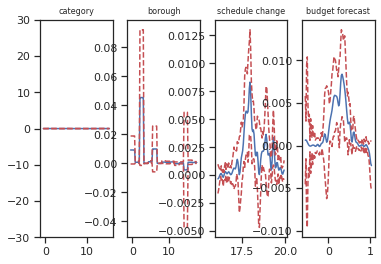

In [0]:
## plotting
plt.figure();
fig, axs = plt.subplots(1,4);

titles = ['category', 'borough', 'schedule change', 'budget forecast']
for i, ax in enumerate(axs):
    XX = nyc_gam1.generate_X_grid(term=i)
    ax.plot(XX[:, i], nyc_gam1.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], nyc_gam1.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i], fontsize=8);

In [0]:
print(nyc_gam1.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      6.0415
Link Function:                     IdentityLink Log Likelihood:                                  -257.6381
Number of Samples:                          113 AIC:                                               529.359
                                                AICc:                                              530.438
                                                GCV:                                                0.1584
                                                Scale:                                              0.1432
                                                Pseudo R-Squared:                                   0.0605
Feature Function                  Lam

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


### Schedule Change GAM Model

In [0]:
nyc_train_g2 = nyc_train_gam.copy()
#nyc_train_trunc = nyc_train_trunc[qual_columns]
y_train_g2 = (nyc_train_g2['Schedule Change Norm'])
X_train_g2 = nyc_train_g2.drop(['Schedule Change Norm', 'Budget Forecast'], axis=1)
nyc_test_g2 = nyc_test_gam.copy()
#nyc_train_trunc = nyc_train_trunc[qual_columns]
y_test_g2 = (nyc_test_g2['Schedule Change Norm'])
X_test_g2 = nyc_test_g2.drop(['Schedule Change Norm', 'Budget Forecast'], axis=1)

In [0]:
np.random.seed(49)
X_trn2, X_val2, y_trn2, y_val2 = train_test_split(X_train_g2, y_train_g2, test_size=0.2)
scores = np.zeros((len(smoothings)))
for j, smoothing in enumerate(smoothings):
    cur_model2 = LinearGAM(formula, lam = smoothing,n_splines=30).fit(X_trn2, y_trn2)
    scores[j] = r2_score(y_val2, cur_model2.predict(X_val2))
                              
best_lambda2 = smoothings[np.argmax(scores, axis = 0)]

In [0]:
np.random.seed(49)
nyc_gam2 = LinearGAM(formula, lam=best_lambda2).fit(X_train_g2, y_train_g2)
r_score_train = r2_score(y_train_g2, nyc_gam2.predict(X_train_g2))
r_score_test = r2_score(y_test_g2, nyc_gam2.predict(X_test_g2))


print('\n###########################################################\n')
print('\n########        Schedule Change Model         #############\n')
print('\n###########################################################\n')
print('Lambda = {:0.3f}'.format(best_lambda2))
print('Training R-Squared = {:0.5f}'.format(r_score_train))
print('Testing R-Squared = {:0.5f}'.format(r_score_test))
print('\n###########################################################\n')


###########################################################


########        Schedule Change Model         #############


###########################################################

Lambda = 3.162
Training R-Squared = 0.20636
Testing R-Squared = 0.03893

###########################################################



<Figure size 1080x3240 with 0 Axes>

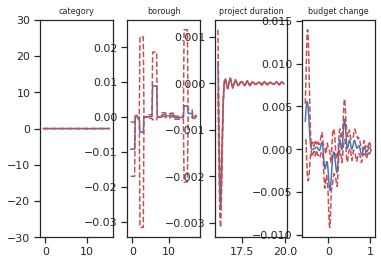

In [0]:
## plotting
plt.figure(figsize=(15,45));
fig, axs = plt.subplots(1,4);

titles = ['category', 'borough', 'project duration', 'budget change']
for i, ax in enumerate(axs):
    XX = nyc_gam2.generate_X_grid(term=i)
    ax.plot(XX[:, i], nyc_gam2.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], nyc_gam2.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i], fontsize=8);

In [0]:
print(nyc_gam2.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.0344
Link Function:                     IdentityLink Log Likelihood:                                  -971.1754
Number of Samples:                          113 AIC:                                             1958.4196
                                                AICc:                                            1959.8159
                                                GCV:                                                0.0488
                                                Scale:                                              0.0434
                                                Pseudo R-Squared:                                   0.2064
Feature Function                  Lam

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


# Neural Network based Models

Although the data is less for what Neural Network mdels require, we wanted to model them anyway. The expectation is that if we had more data or can acquire more data, we could run through these models with the expectation to get better scores 

### Basic Requirement checks and imports

In [0]:
%tensorflow_version 2.0.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.0.0`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
!pip install tensorflow==2.0.0
!pip install tf_keras_vis
#Getting all pip packages
import subprocess
import sys
reqs = subprocess.check_output([sys.executable, '-m', 'pip', 'freeze'])
installed_packages = [r.decode().split('==') for r in reqs.split()]
#installing tensorflow-datasets==2.1.0
if ['tensorflow-datasets', '2.1.0'] not in installed_packages:
  !pip uninstall tensorflow-datasets -y
  !pip install tensorflow-datasets==2.1.0 
#installing tensorflow-addons==0.6.0
if ['tensorflow-addons', '0.6.0'] not in installed_packages:
  !pip uninstall tensorflow-addons -y
  !pip install tensorflow-addons==0.6.0

In [0]:

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import *

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Reshape, Concatenate, Lambda
from tensorflow.keras.optimizers import Adam, SGD

## Neural Network with PCA

In [0]:
input = Input(shape=(28,))
input_1 = Lambda(lambda x: x[:, 0:4])(input)
input_2 = Lambda(lambda x: x[:, 4:28])(input)
dense1 = Dense(8, name='description', activation='linear')(input_2)
dense2 = Dense(2, activation='linear')(input_1)
conc1 = Concatenate(axis = 1)([dense1, dense2])
output = Dense(1, activation='linear')(conc1)
model = tf.keras.Model(input, output)
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28)]         0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 24)           0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4)            0           input_1[0][0]                    
__________________________________________________________________________________________________
description (Dense)             (None, 8)            200         lambda_1[0][0]                   
______________________________________________________________________________________________

In [0]:
np.random.seed(49)
nyc_train_gam, nyc_test_gam = train_test_split(nyc_df_gam, test_size=.1, random_state=49)
np.shape(nyc_df_gam)
nyc_train_nn1 = nyc_train_gam.copy()
#nyc_train_trunc = nyc_train_trunc[qual_columns]
y_train_nn1 = (nyc_train_nn1['Budget Change Norm'])
X_train_nn1 = nyc_train_nn1.drop(['Budget Change Norm', 'Project Duration'], axis=1)
nyc_test_nn1 = nyc_test_gam.copy()
#nyc_train_trunc = nyc_train_trunc[qual_columns]
y_test_nn1 = (nyc_test_nn1['Budget Change Norm'])
X_test_nn1 = nyc_test_nn1.drop(['Budget Change Norm', 'Project Duration'], axis=1)
np.shape(nyc_train_gam)

(127, 30)

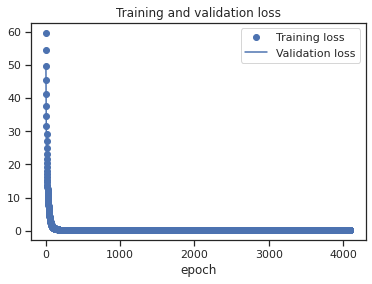

Final Training Loss: 0.08865058517987186
Final Validation Loss: 0.11350513421572171


In [0]:
history = model.fit(X_train_nn1.values, y_train_nn1.values, epochs=4096, batch_size=16, verbose=False, shuffle=True, validation_split=0.2)
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    print(f'Final Training Loss: {final_train_loss}')
    print(f'Final Validation Loss: {final_val_loss}')
plot_training_history(history)

In [0]:
score, _ = model.evaluate(X_test_nn1.values, y_test_nn1.values,batch_size=32)
print('Test score:', score)

15/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 204us/sample - loss: 0.3915 - accuracy: 0.0000e+00
Test score: 0.3914526700973511


### Schedule Change Model

In [0]:
model2 = tf.keras.models.clone_model(model)
model2.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28)]         0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 24)           0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4)            0           input_1[0][0]                    
__________________________________________________________________________________________________
description (Dense)             (None, 8)            200         lambda_1[0][0]                   
______________________________________________________________________________________________

In [0]:
nyc_train_nn2 = nyc_train_gam.copy()
y_train_nn2 = (nyc_train_nn2['Schedule Change Norm'])
X_train_nn2 = nyc_train_nn2.drop(['Schedule Change Norm', 'Budget Forecast'], axis=1)
nyc_test_nn2 = nyc_test_gam.copy()
y_test_nn2 = (nyc_test_nn2['Schedule Change Norm'])
X_test_nn2 = nyc_test_nn2.drop(['Schedule Change Norm', 'Budget Forecast'], axis=1)

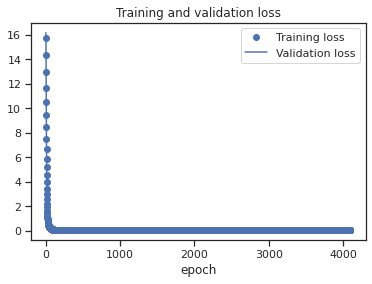

Final Training Loss: 0.021673316486401133
Final Validation Loss: 0.10340604873803946


In [0]:
history2 = model2.fit(X_train_nn2.values, y_train_nn2.values, epochs=4096, batch_size=16, verbose=False, shuffle=True, validation_split=0.2)
plot_training_history(history2)

In [0]:
score, _ = model2.evaluate(X_test_nn2.values, y_test_nn2.values,batch_size=32)
print('Test score:', score)

15/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 224us/sample - loss: 0.0626 - accuracy: 0.0667
Test score: 0.06263182312250137


## Neural Network with AutoEncoder

### Training and test data

In [0]:
qual_nn_cols = ['Category', 'Borough', 'Budget Forecast','Project Duration','Schedule Change Norm','Budget Change Norm']
nn_df = df[qual_nn_cols].copy()
nn_df = nn_df.reset_index(drop=True).merge(df_embed.reset_index(drop=True), left_index=True, right_index=True)
nn_df = nn_df.dropna()
# TRANSFORM
nn_df['Budget Forecast'] = np.log(nn_df['Budget Forecast'])
nn_df['Project Duration'] = np.log(nn_df['Project Duration'])
nn_df = get_gam_x(nn_df)
np.shape(nn_df)

(142, 518)

In [0]:
np.random.seed(49)
nn_train, nn_test = train_test_split(nn_df, test_size=.1, random_state=49)
nyc_train_nn3 = nn_train.copy()
y_train_nn3 = (nyc_train_nn3['Budget Change Norm'])
X_train_nn3 = nyc_train_nn3.drop(['Budget Change Norm', 'Project Duration'], axis=1)

nyc_test_nn3 = nn_test.copy()
y_test_nn3 = (nyc_test_nn3['Budget Change Norm'])
X_test_nn3 = nyc_test_nn3.drop(['Budget Change Norm', 'Project Duration'], axis=1)
np.shape(X_train_nn3)

(127, 516)

### Budget Change Model

In [0]:
input = Input(shape=(516,))
input_1 = Lambda(lambda x: x[:, 0:4])(input)
input_2 = Lambda(lambda x: x[:, 4:516])(input)
dense1 = Dense(16, activation='relu')(input_2)
dense2 = Dense(4, activation='linear')(dense1)
dense3 = Dense(2, activation='linear')(input_1)
conc1 = Concatenate(axis = 1)([dense2, dense3])
output = Dense(1, activation='linear')(conc1)
model3 = tf.keras.Model(input, output)
model3.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model3.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 516)]        0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 512)          0           input_4[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 16)           8208        lambda_7[0][0]                   
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 4)            0           input_4[0][0]                    
____________________________________________________________________________________________

In [0]:
# Auto-encoder
decoder = Dense(512,activation='relu', use_bias=True, bias_initializer='zeros')(input_2)
ae = Model(input, decoder)
ae.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
ae.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 516)]             0         
_________________________________________________________________
lambda_7 (Lambda)            (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
Total params: 262,656
Trainable params: 262,656
Non-trainable params: 0
_________________________________________________________________


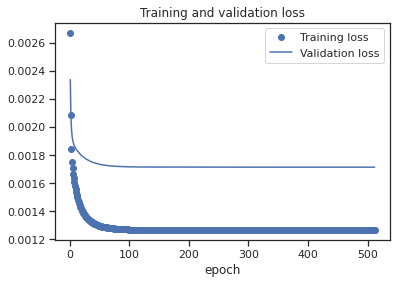

Final Training Loss: 0.0012638785641197817
Final Validation Loss: 0.001714547397568822


In [0]:
ae_history = ae.fit(X_train_nn3.values, X_train_nn3.iloc[:,4:516].values, epochs=512, batch_size=32, shuffle=True, verbose=0, validation_split=0.2)
plot_training_history(ae_history)

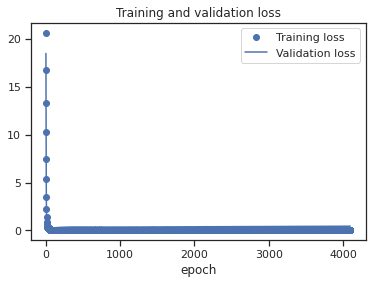

Final Training Loss: 0.0005945676550416664
Final Validation Loss: 0.4428022503852844


In [0]:
# Don't train AE Encoder layer
np.random.seed(49)
dense1.trainable=False
history3 = model3.fit(X_train_nn3.values, y_train_nn3.values, epochs=4096, batch_size=16, verbose=False, shuffle=True, validation_split=0.2)
plot_training_history(history3)

In [0]:
score, _ = model3.evaluate(X_test_nn3.values, y_test_nn3.values,batch_size=32)
print('Test score:', score)

15/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 278us/sample - loss: 0.2344 - accuracy: 0.0000e+00
Test score: 0.23435163497924805


### Schedule Change Model

In [0]:
y_train_nn4 = (nyc_train_nn3['Schedule Change Norm'])
X_train_nn4 = nyc_train_nn3.drop(['Schedule Change Norm', 'Budget Forecast'], axis=1)

y_test_nn4 = (nyc_test_nn3['Schedule Change Norm'])
X_test_nn4 = nyc_test_nn3.drop(['Schedule Change Norm', 'Budget Forecast'], axis=1)
np.shape(X_train_nn4)

(127, 516)

In [0]:
input = Input(shape=(516,))
input_1 = Lambda(lambda x: x[:, 0:4])(input)
input_2 = Lambda(lambda x: x[:, 4:516])(input)
dense1 = Dense(8, activation='relu')(input_2)
dense2 = Dense(4, activation='linear')(dense1)
dense3 = Dense(2, activation='linear')(input_1)
conc1 = Concatenate(axis = 1)([dense2, dense3])
output = Dense(1, activation='linear')(conc1)
model4 = tf.keras.Model(input, output)
model4.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model4.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 516)]        0                                            
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 512)          0           input_7[0][0]                    
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 8)            4104        lambda_13[0][0]                  
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 4)            0           input_7[0][0]                    
___________________________________________________________________________________________

In [0]:
# Auto-encoder
decoder = Dense(512,activation='relu', use_bias=True, bias_initializer='zeros')(input_2)
ae2 = Model(input, decoder)
ae2.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
ae2.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 516)]             0         
_________________________________________________________________
lambda_13 (Lambda)           (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               262656    
Total params: 262,656
Trainable params: 262,656
Non-trainable params: 0
_________________________________________________________________


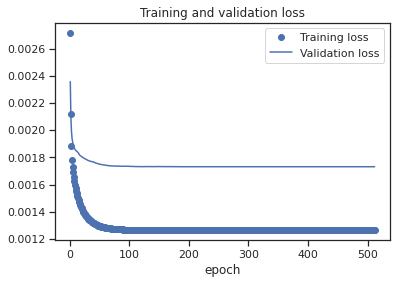

Final Training Loss: 0.001262398614170085
Final Validation Loss: 0.0017309060785919428


In [0]:
ae2_history = ae2.fit(X_train_nn4.values, X_train_nn4.iloc[:,4:516].values, epochs=512, batch_size=32, shuffle=True, verbose=0, validation_split=0.2)
plot_training_history(ae2_history)

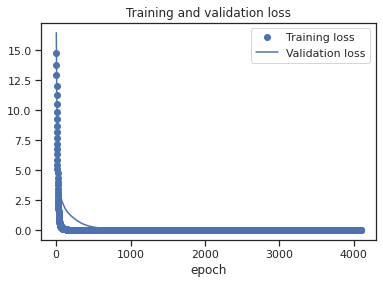

Final Training Loss: 0.0004298113582522227
Final Validation Loss: 0.14809413999319077


In [0]:
# Don't train AE Encoder layer
np.random.seed(49)
dense1.trainable=False
history4 = model4.fit(X_train_nn4.values, y_train_nn4.values, epochs=4096, batch_size=16, verbose=False, shuffle=True, validation_split=0.2)
plot_training_history(history4)

In [0]:
score, _ = model4.evaluate(X_test_nn4.values, y_test_nn4.values,batch_size=32)
print('Test score:', score)

15/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 256us/sample - loss: 0.0940 - accuracy: 0.0667
Test score: 0.0939520075917244


# Summary

1) Target variables - Success criteria not trivial to define.

2) EDA - Feature engineering, Transformations

3) NLP and Dimensionality Reduction - Used Google's Auto Encoder model to transform desciption to 512 size vector. Added them as columns and used PCA/AutoEncoder to reduce dimensions

4) Models - Linear Regression, Ridge, Lasso, GAM, Bagging and Neural Network based Models

5) More Data - If there were more data, we could make use of Deep Learning more effectively

6) Goal: The objective was to try various models learned across the two 109 courses.

To summarize, we have seen that the performance improves when we are using NLP and Neural Network. With the current size of training data, we used linear models to avoid overfitting. With more training data, we will be able to introduce non-linearity into our models. Additional information such as progress reports or performance review will allow us to extract more information using advanced NLP techniques.

We would like to take this opportunity to thank the professors and the TFs for all the help in the two courses (109a and b). We hope to learn more from our peers who are doing Project E.
